# Tree Numbers and Subsampling Features

### Loading Data

Let's work with our women shoes price data.

In [1]:
from sklearn.model_selection import train_test_split
import json
import pandas as pd
import numpy as np

df = pd.read_csv('df2.csv')

X = df.drop(columns=['Unnamed: 0', 'prices.amountMax'])
y = df['prices.amountMax']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [2]:
X_train.shape

(3428, 102)

In [3]:
X_test.shape

(1072, 102)

In [4]:
X_val.shape

(857, 102)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5357 entries, 0 to 5356
Columns: 104 entries, Unnamed: 0 to prices.currency_USD
dtypes: bool(7), float64(1), int64(96)
memory usage: 4.0 MB


### Number of trees

One hyperparameter that we can vary with sklearn is the number of estimators of our random forest.  Now, in general, increasing the number of trees should improve our model.  With more trees, our trees will be more varied, thus reducing the error due to variance when we aggregate our trees.  In addition, we expect more of our trees to find the underlying pattern in the data thus reducing the bias of our random forest.  

However, at a certain point, adding new estimators will only provide a small benefit as they begin to be similar to earlier trained estimators.  At this point, the main cost is simply the time that it takes to work on our random forest. 

Let's see the benefit of adding additional trees.  We can do so by training one large random forest, and then seeing the improvement of including an additional estimator.

In [7]:
X_train.shape

(3428, 102)

In [8]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 100)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [9]:
tree_predictions = np.vstack([estimator.predict(X_val) for estimator in rfr.estimators_])

Each row of `tree_predictions` contains a separate prediction for each observation in the validation set made by the respective tree.

In [10]:
tree_predictions.shape

(100, 857)

In [11]:
tree_predictions[:10]

array([[ 60.29      ,  19.96      ,  98.3       , ..., 108.68833333,
        110.9       ,  24.99      ],
       [ 30.82333333,  81.38      ,  81.07428571, ...,  83.16428571,
         89.9       ,  20.99      ],
       [ 13.65666667,  19.96      ,  87.61714286, ..., 110.34      ,
        134.9       ,  15.49      ],
       ...,
       [ 52.76777778,  19.96      ,  81.75      , ...,  97.06      ,
         98.9       ,  34.74      ],
       [ 44.26272727,  19.96      ,  93.09444444, ..., 103.36833333,
        117.75714286,  15.32333333],
       [ 40.99      ,  75.        ,  73.78142857, ..., 115.96833333,
         84.9       ,  23.39      ]])

Then we can see the benefit of taking the mean aggregation of each additional tree.

In [12]:
from sklearn.metrics import r2_score
r2_scores = [r2_score(y_val, np.mean(tree_predictions[:i + 1], axis = 0)) for i in range(0, 100)]
x_vals = list(range(1, 100))

Let's plot the data.

In [13]:
from graph import trace_values, plot
trace = trace_values(x_vals, r2_scores)
plot([trace])

So we can see that our accuracy level stabalizes around 30 trees.  Fitting this model with 30 trees still takes a while, so just for the purpose of developing our model, we'll knock it down to 20 trees, which also performs well.

### Subsampling Features

The next hyperparameter to work with is sampling the features at each split.  Here is how it works:

* For each split, the random forest first takes a random sample of the features, and then determines what the next best split is from this subsample.  

The idea behind this is to again increase the variation of the trees.  The problem if that certain features are dominant, the features will be repeatedly selected early and this can have a large impact on what occurs later in the trees.  

Let's see this by looking at the first two estimators of the random forest we just trained.

* plot the first estimator, with the plot set to a max_depth of 1

In [14]:
from plot_tree import plot_tree

In [15]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [16]:
def feature_sampling_scores (max_features_list):
    feature_sampling_scores_list = []
    for max_feature in max_features_list:
        rfr = RandomForestRegressor(max_features=max_feature, random_state=1)
        rfr.fit(X_train, y_train)
        score = (max_feature, rfr.score(X_val,y_val))
        feature_sampling_scores_list.append(score)
    return feature_sampling_scores_list

In [17]:
feature_sampling_scores([0.5,'log2','sqrt',None])

C:\Users\51759\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\51759\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\51759\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\51759\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



[(0.5, 0.558681193638169),
 ('log2', 0.5800808753821141),
 ('sqrt', 0.568869988999662),
 (None, 0.5695249500923423)]

### 3. Number of leaves

In [18]:
min_samples = np.arange(2,51,5)
min_samples

array([ 2,  7, 12, 17, 22, 27, 32, 37, 42, 47])

In [19]:
def num_leaves_wrapped_scores (min_samples):
    num_leaves_wrapped_scores_list = []
    for min_sample in min_samples:
        rfr = RandomForestRegressor(n_estimators=50, min_samples_leaf=min_sample, random_state=1)
        rfr.fit(X_train, y_train)
        score = rfr.score(X_val,y_val)
        num_leaves_wrapped_scores_list.append(score)
    return num_leaves_wrapped_scores_list

In [20]:
scores = num_leaves_wrapped_scores(min_samples)

In [21]:
scores[:5]

[0.6006395918068812,
 0.584262634140373,
 0.5560724861850751,
 0.5331077059829161,
 0.4996094867340214]

In [157]:
wrapped_scores = np.column_stack((min_samples, scores))

In [158]:
trace_1 = trace_values(wrapped_scores[:, 0], wrapped_scores[:, 1])

In [159]:
plot([trace_1])

* The more number of leaves, the lower score we get. The highest score locates at the number of leaves of 3.

In [160]:
combined_X = np.vstack((X_train, X_val))

In [161]:
combined_y = np.concatenate((y_train, y_val))

In [162]:
rfr3 = RandomForestRegressor(n_estimators=50, random_state=1, max_features=0.5)
rfr3.fit(combined_X, combined_y)
rfr3.score(X_test,y_test)

0.5947623887175424

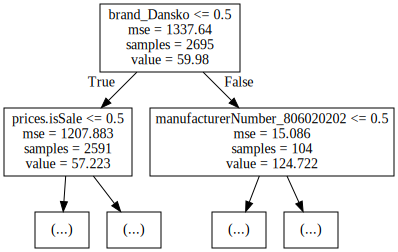

In [163]:
plot_tree(rfr3[0], X.columns, max_depth=1)

* plot the second estimator, with the plot set to a max_depth of 1

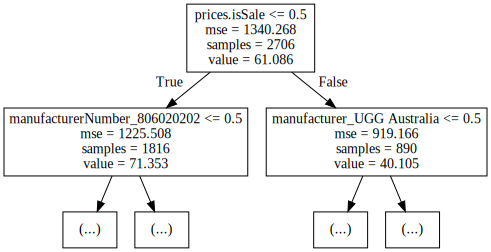

In [164]:
plot_tree(rfr3[1], X.columns, max_depth=1)

Now we can see, we can get the different tree by using max_features argument. It can generate more varience to models.